In [ ]:
# Install required packages
!pip install catboost
!pip install gpytorch
!pip install seaborn
!pip install gym
!pip install stable-baselines3
!pip install pybullet
!pip install gymnasium
!pip install tensorflow
!apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [ ]:
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/EVD/data/'

Mounted at /content/drive


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Found GPU at: /device:GPU:0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10306553945370717582
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14619377664
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 875348535086070207
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from sklearn.mixture import GaussianMixture
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import SAC
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback

# GP-specific imports
import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import VariationalELBO

# Load the dataset
df = pd.read_csv(data_path + "helsinki_ev_data_price.csv")

# Shuffle the dataset
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Select the first 30,000 samples
df_subset = df_shuffled.head(30000)

# Define features and target
features_to_drop = ['Day','Time (HH:MM:SS)', 'Charging_Event (Count)', 'Charging_Demand (kWh)']
X = df_subset.drop(features_to_drop, axis=1)
y = df_subset['Charging_Demand (kWh)'].astype(float)  # Explicitly convert to float

# Identify categorical features
categorical_features = ['Region_ID']
numerical_features = [col for col in X.columns if col not in categorical_features]

# Normalize numerical features
scaler = MinMaxScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Initialize k-fold cross-validation
k_folds = 10
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Define the GP model (same as your GP model)
class SingleLayerGP(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution)
        super().__init__(variational_strategy)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Hybrid Environment combining both prediction models
class HybridEVChargingEnv(gym.Env):
    def __init__(self, catboost_model, gp_model, gp_likelihood, X_data, y_data):
        super(HybridEVChargingEnv, self).__init__()

        self.catboost_model = catboost_model
        self.gp_model = gp_model
        self.gp_likelihood = gp_likelihood
        self.X_data = X_data.values if hasattr(X_data, 'values') else X_data
        self.y_data = y_data.values if hasattr(y_data, 'values') else y_data
        self.current_idx = 0

        # Enhanced price parameters (same as your models)
        self.P_base = 0.25   # EUR/kWh
        self.P_min = 0.20
        self.P_max = 0.40
        self.alpha = 0.15

        # Initialize current_price
        self.current_price = self.P_base

        # Smoothing buffers
        self.price_memory = deque(maxlen=5)  # For action smoothing
        self.demand_memory = deque(maxlen=3) # For demand smoothing

        # Enhanced constraints
        self.max_daily_price_change = 0.10  # Max 10% daily variation
        self.target_load = np.mean(y_data)
        self.L_th = self.target_load * 1.5

        # Observation/action spaces
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 0, 0, 0, self.P_min]),
            high=np.array([np.inf, np.inf, 100, np.inf, np.inf, np.inf, self.P_max]),
            dtype=np.float32
        )
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)

        # Enhanced driver behavior model (same as your models)
        self.n_clusters = 3
        self.gmm = GaussianMixture(n_components=self.n_clusters)
        demands = self.y_data.reshape(-1, 1)
        self.gmm.fit(demands)
        self.gamma_k = np.array([0.8, 0.5, 0.3])  # Price sensitivity coefficients

        # Add demand tracking
        self.demand_history = []
        self.deviation_history = []
        self.target_load = np.mean(y_data)

    def _fit_driver_model(self):
        """Fit Gaussian Mixture Model to historical demand data"""
        demands = self.y_data.reshape(-1, 1)
        self.gmm.fit(demands)

    def _get_driver_response(self, price_change):
        """Simulate driver response to price change using GMM"""
        L_base, cluster = self.gmm.sample()
        L_base = L_base[0, 0]
        gamma = self.gamma_k[cluster[0]]
        L_t = L_base * (1 - gamma * price_change)
        return max(0, L_t)

    def _get_state(self, features):
        """Create state vector using hybrid prediction"""
        # CatBoost prediction
        features_df = pd.DataFrame([features], columns=X.columns)
        features_df[categorical_features] = features_df[categorical_features].astype(str)
        pool = Pool(features_df, cat_features=categorical_features)
        cb_pred = max(0, self.catboost_model.predict(pool)[0])

        # GP prediction
        features_tensor = torch.tensor(features.reshape(1, -1), dtype=torch.float32)
        if torch.cuda.is_available():
            features_tensor = features_tensor.cuda()

        self.gp_model.eval()
        self.gp_likelihood.eval()

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = self.gp_likelihood(self.gp_model(features_tensor))
            gp_pred = observed_pred.mean.item()

        # Combine predictions (simple average)
        hybrid_pred = (cb_pred + gp_pred) / 2

        return np.array([
            hybrid_pred, 1.0, 50.0, 20.0, 12.0, 1.0, self.current_price
        ], dtype=np.float32)

    def _enhanced_reward(self, current_demand, previous_demand, price_change, deviation):
        """New reward with demand growth penalty (same as your models)"""
        demand_growth_penalty = -0.5 * max(0, current_demand - previous_demand)
        reward = (
            -0.7 * (deviation ** 2) +
            -0.3 * (price_change ** 2) +
            -1.5 * max(0, current_demand - self.target_load) +
            demand_growth_penalty  # Penalize demand increases
        )
        if abs(price_change) > self.max_daily_price_change:
            reward -= 0.5 * (abs(price_change) - self.max_daily_price_change) ** 2
        return reward

    def step(self, action):
        # Action smoothing
        self.price_memory.append(action[0])
        smoothed_action = np.mean(self.price_memory)

        # Price adjustment
        price_adjustment = smoothed_action * 1.5
        new_price = self.P_base + self.alpha * price_adjustment
        new_price = np.clip(new_price, self.P_min, self.P_max)
        price_change = (new_price - self.current_price)/self.current_price

        # Get driver response
        price_change_pct = (new_price - self.P_base)/self.P_base
        actual_demand = self._get_driver_response(price_change_pct)
        self.demand_memory.append(actual_demand)

        # Calculate reward
        deviation = actual_demand - self.target_load
        reward = self._enhanced_reward(
            actual_demand,
            self.demand_memory[-2] if len(self.demand_memory) > 1 else actual_demand,
            price_change,
            deviation
        )

        # Store demand and deviation
        self.demand_history.append(actual_demand)
        self.deviation_history.append(deviation)

        # Update state
        self.current_idx = (self.current_idx + 1) % len(self.X_data)
        next_state = self._get_state(self.X_data[self.current_idx])
        next_state[-1] = new_price
        self.current_state = next_state
        self.current_price = new_price

        return next_state, reward, False, False, {
            'price': new_price,
            'demand': actual_demand,
            'deviation': deviation,
            'target_demand': self.target_load
        }

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_idx = 0
        self.current_state = self._get_state(self.X_data[self.current_idx])
        self.current_price = self.P_base
        return self.current_state, {}

# Enhanced CatBoost parameters (same as your CatBoost model)
catboost_params = {
    'iterations': 1200,
    'learning_rate': 0.025,
    'depth': 7,
    'l2_leaf_reg': 3,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'random_seed': 42,
    'od_type': 'Iter',
    'od_wait': 100,
    'verbose': 100,
    'task_type': 'GPU' if torch.cuda.is_available() else 'CPU',
    'border_count': 128
}

# Initialize results storage
hybrid_rl_results = {
    'train_loss': [], 'val_loss': [], 'train_r2': [], 'val_r2': [],
    'train_mae': [], 'val_mae': [], 'train_rmse': [], 'val_rmse': [],
    'test_metrics': [], 'test_predictions': [], 'feature_importances': [],
    'training_times': [], 'best_iterations': [], 'rl_rewards': [],
    'rl_prices': [], 'rl_demands': [], 'gp_losses': [], 'gp_epochs': []
}

# K-fold cross-validation loop with RL integration
for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"\n=== Fold {fold + 1}/{k_folds} ===")

    # Split data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Further split into train/val
    val_size = 0.15
    split_idx = int(len(X_train) * (1 - val_size))
    X_train_fold, X_val_fold = X_train[:split_idx], X_train[split_idx:]
    y_train_fold, y_val_fold = y_train[:split_idx], y_train[split_idx:]

    # Create CatBoost Pool objects
    train_pool = Pool(X_train_fold, y_train_fold, cat_features=categorical_features)
    val_pool = Pool(X_val_fold, y_val_fold, cat_features=categorical_features)
    test_pool = Pool(X_test, y_test, cat_features=categorical_features)

    # Time the training
    start_time = time.time()

    # Initialize and train CatBoost model
    cb_model = CatBoostRegressor(**catboost_params)
    cb_model.fit(
        train_pool,
        eval_set=val_pool,
        use_best_model=True,
        plot=False
    )

    # Prepare data for GP (convert categorical to numerical)
    X_train_gp = X_train_fold.copy()
    X_val_gp = X_val_fold.copy()
    X_test_gp = X_test.copy()

    X_train_gp[categorical_features] = X_train_gp[categorical_features].astype(int)
    X_val_gp[categorical_features] = X_val_gp[categorical_features].astype(int)
    X_test_gp[categorical_features] = X_test_gp[categorical_features].astype(int)

    # Feature scaling for GP
    gp_scaler = StandardScaler()
    X_train_gp = gp_scaler.fit_transform(X_train_gp)
    X_val_gp = gp_scaler.transform(X_val_gp)
    X_test_gp = gp_scaler.transform(X_test_gp)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_gp, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val_gp, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_gp, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_fold.values, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_fold.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

    # Initialize GP model
    num_inducing_points = min(300, len(X_train_tensor))
    inducing_points = X_train_tensor[:num_inducing_points]
    gp_model = SingleLayerGP(inducing_points)
    gp_likelihood = GaussianLikelihood()

    # Move to GPU if available
    if torch.cuda.is_available():
        gp_model = gp_model.cuda()
        gp_likelihood = gp_likelihood.cuda()
        X_train_tensor = X_train_tensor.cuda()
        y_train_tensor = y_train_tensor.cuda()
        X_val_tensor = X_val_tensor.cuda()
        y_val_tensor = y_val_tensor.cuda()
        X_test_tensor = X_test_tensor.cuda()
        y_test_tensor = y_test_tensor.cuda()
        inducing_points = inducing_points.cuda()

    # Optimizer and loss for GP
    optimizer = torch.optim.Adam([
        {'params': gp_model.parameters()},
        {'params': gp_likelihood.parameters()}
    ], lr=0.01)
    mll = VariationalELBO(gp_likelihood, gp_model, num_data=X_train_tensor.size(0))

    # GP Training loop
    train_losses = []
    val_losses = []
    patience = 300
    epochs_without_improvement = 0
    best_val_loss = float('inf')

    gp_start_time = time.time()
    num_epochs = 500
    for epoch in range(num_epochs):
        # Training
        gp_model.train()
        gp_likelihood.train()
        optimizer.zero_grad()
        output = gp_model(X_train_tensor)
        loss = -mll(output, y_train_tensor)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Validation
        gp_model.eval()
        gp_likelihood.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            val_output = gp_likelihood(gp_model(X_val_tensor))
            val_loss = -mll(val_output, y_val_tensor).item()
            val_losses.append(val_loss)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"GP early stopping at epoch {epoch + 1}")
                break

    gp_end_time = time.time()
    gp_training_time = gp_end_time - gp_start_time

    # Store GP training info
    hybrid_rl_results['gp_losses'].append({'train': train_losses, 'val': val_losses})
    hybrid_rl_results['gp_epochs'].append(len(train_losses))

    # Calculate CatBoost metrics
    def calculate_metrics(pool, y_true, model):
        y_pred = model.predict(pool)
        return {
            'r2': r2_score(y_true, y_pred),
            'mae': mean_absolute_error(y_true, y_pred),
            'rmse': np.sqrt(mean_squared_error(y_true, y_pred))
        }

    # CatBoost training metrics
    cb_train_metrics = calculate_metrics(train_pool, y_train_fold, cb_model)
    cb_val_metrics = calculate_metrics(val_pool, y_val_fold, cb_model)

    # GP metrics
    def calculate_gp_metrics(X_tensor, y_true):
        gp_model.eval()
        gp_likelihood.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            preds = gp_likelihood(gp_model(X_tensor))
            y_pred = preds.mean.cpu().numpy()
            y_true = y_true.cpu().numpy()
            return {
                'r2': r2_score(y_true, y_pred),
                'mae': mean_absolute_error(y_true, y_pred),
                'rmse': np.sqrt(mean_squared_error(y_true, y_pred))
            }

    gp_train_metrics = calculate_gp_metrics(X_train_tensor, y_train_tensor)
    gp_val_metrics = calculate_gp_metrics(X_val_tensor, y_val_tensor)

    # Hybrid predictions (average of both models)
    def hybrid_predict(X_data, y_true=None):
        # CatBoost prediction
        cb_pred = cb_model.predict(X_data)

        # GP prediction
        X_gp = X_data.copy()
        X_gp[categorical_features] = X_gp[categorical_features].astype(int)
        X_gp = gp_scaler.transform(X_gp)
        X_tensor = torch.tensor(X_gp, dtype=torch.float32)
        if torch.cuda.is_available():
            X_tensor = X_tensor.cuda()

        gp_model.eval()
        gp_likelihood.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            gp_pred = gp_likelihood(gp_model(X_tensor)).mean.cpu().numpy()

        # Combine predictions
        hybrid_pred = (cb_pred + gp_pred) / 2

        if y_true is not None:
            return {
                'r2': r2_score(y_true, hybrid_pred),
                'mae': mean_absolute_error(y_true, hybrid_pred),
                'rmse': np.sqrt(mean_squared_error(y_true, hybrid_pred))
            }
        return hybrid_pred

    # Test evaluation
    test_metrics = hybrid_predict(X_test, y_test)
    test_predictions = hybrid_predict(X_test)

    hybrid_rl_results['test_predictions'].append(test_predictions)
    hybrid_rl_results['test_metrics'].append(test_metrics)

    end_time = time.time()
    fold_time = end_time - start_time
    hybrid_rl_results['training_times'].append(fold_time)
    hybrid_rl_results['best_iterations'].append(cb_model.best_iteration_)

    print(f"\nFold {fold + 1} Results:")
    print(f"Training time: {fold_time:.2f} seconds")
    print(f"CatBoost best iteration: {cb_model.best_iteration_}")
    print(f"GP training epochs: {len(train_losses)}")

    print("\nCatBoost Metrics:")
    print(f"Train MAE: {cb_train_metrics['mae']:.4f}, Val MAE: {cb_val_metrics['mae']:.4f}")
    print(f"Train RMSE: {cb_train_metrics['rmse']:.4f}, Val RMSE: {cb_val_metrics['rmse']:.4f}")
    print(f"Train R²: {cb_train_metrics['r2']:.4f}, Val R²: {cb_val_metrics['r2']:.4f}")

    print("\nGP Metrics:")
    print(f"Train MAE: {gp_train_metrics['mae']:.4f}, Val MAE: {gp_val_metrics['mae']:.4f}")
    print(f"Train RMSE: {gp_train_metrics['rmse']:.4f}, Val RMSE: {gp_val_metrics['rmse']:.4f}")
    print(f"Train R²: {gp_train_metrics['r2']:.4f}, Val R²: {gp_val_metrics['r2']:.4f}")

    print("\nHybrid Test Metrics:")
    print(f"MAE: {test_metrics['mae']:.4f}, RMSE: {test_metrics['rmse']:.4f}, R²: {test_metrics['r2']:.4f}")

    # Initialize RL environment with hybrid model
    env = HybridEVChargingEnv(cb_model, gp_model, gp_likelihood, X_val_fold, y_val_fold)
    check_env(env)

    # Custom callback to track rewards and prices
    class CustomCallback(BaseCallback):
        def __init__(self, verbose=0):
            super(CustomCallback, self).__init__(verbose)
            self.rewards = []
            self.prices = []
            self.demands = []

        def _on_step(self) -> bool:
            info = self.locals['infos'][0]
            self.rewards.append(self.locals['rewards'][0])
            self.prices.append(info['price'])
            self.demands.append(info['demand'])
            return True

    callback = CustomCallback()

    # Train the SAC agent (same parameters as your models)
    sac_agent = SAC(
        'MlpPolicy',
        env,
        verbose=1,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        learning_rate=3e-4,
        buffer_size=300000,
        batch_size=1024,
        ent_coef='auto',
        gamma=0.99,
        tau=0.005,
        policy_kwargs=dict(net_arch=[256, 256]))

    sac_agent.learn(total_timesteps=50000, callback=callback)

    # Store RL results
    hybrid_rl_results['rl_rewards'].append(callback.rewards)
    hybrid_rl_results['rl_prices'].append(callback.prices)
    hybrid_rl_results['rl_demands'].append(callback.demands)

    print(f"\nRL Training completed for fold {fold + 1}")
    print(f"Average Reward: {np.mean(callback.rewards):.2f}")
    print(f"Price Range: {np.min(callback.prices):.3f}-{np.max(callback.prices):.3f} EUR/kWh")
    print(f"Average Demand: {np.mean(callback.demands):.2f} kWh")

# Calculate and display final results
avg_test_mae = np.mean([res['mae'] for res in hybrid_rl_results['test_metrics']])
avg_test_rmse = np.mean([res['rmse'] for res in hybrid_rl_results['test_metrics']])
avg_test_r2 = np.mean([res['r2'] for res in hybrid_rl_results['test_metrics']])
avg_training_time = np.mean(hybrid_rl_results['training_times'])
avg_iterations = np.mean(hybrid_rl_results['best_iterations'])
avg_gp_epochs = np.mean(hybrid_rl_results['gp_epochs'])

# Calculate RL metrics
all_prices = np.concatenate(hybrid_rl_results['rl_prices'])
all_demands = np.concatenate(hybrid_rl_results['rl_demands'])
price_elasticity = np.corrcoef(all_prices, all_demands)[0, 1]

print("\n=== Final Hybrid CatBoost-GP with RL Cross-Validation Results ===")
print(f"Average Test MAE across {k_folds} folds: {avg_test_mae:.4f}")
print(f"Average Test RMSE across {k_folds} folds: {avg_test_rmse:.4f}")
print(f"Average Test R² across {k_folds} folds: {avg_test_r2:.4f}")
print(f"\nAverage training time per fold: {avg_training_time:.2f} seconds")
print(f"Average CatBoost best iterations: {avg_iterations:.1f}")
print(f"Average GP training epochs: {avg_gp_epochs:.1f}")
print(f"\nRL Performance Summary:")
print(f"Average Price: {np.mean(all_prices):.3f} ± {np.std(all_prices):.3f} EUR/kWh")
print(f"Price Elasticity: {price_elasticity:.3f}")
print(f"Average Demand: {np.mean(all_demands):.2f} kWh")



# Save results function
def save_hybrid_rl_results():
    results = {
        'avg_test_metrics': {
            'mae': avg_test_mae,
            'rmse': avg_test_rmse,
            'r2': avg_test_r2
        },
        'timing': {
            'per_fold_times': hybrid_rl_results['training_times'],
            'average_time': avg_training_time,
            'per_fold_iterations': hybrid_rl_results['best_iterations'],
            'average_iterations': avg_iterations,
            'gp_epochs': hybrid_rl_results['gp_epochs'],
            'average_gp_epochs': avg_gp_epochs
        },
        'test_results': {
            'y_true': np.concatenate([y.iloc[test_idx] for _, test_idx in kf.split(X)]),
            'y_pred': np.concatenate(hybrid_rl_results['test_predictions']),
            'metrics': hybrid_rl_results['test_metrics']
        },
        'rl_results': {
            'rewards': hybrid_rl_results['rl_rewards'],
            'prices': hybrid_rl_results['rl_prices'],
            'demands': hybrid_rl_results['rl_demands'],
            'price_stats': {
                'mean': np.mean(all_prices),
                'std': np.std(all_prices),
                'min': np.min(all_prices),
                'max': np.max(all_prices)
            },
            'elasticity': price_elasticity
        },
        'feature_importances': {
            'catboost_importances': hybrid_rl_results['feature_importances'],
            'feature_names': list(X.columns)
        },
        'metadata': {
            'model_type': 'Hybrid CatBoost-GP with SAC Pricing',
            'catboost_parameters': catboost_params,
            'gp_parameters': {
                'kernel': 'RBF',
                'variational_strategy': 'Cholesky',
                'num_inducing_points': 300
            },
            'env_parameters': {
                'P_base': 0.25,
                'P_min': 0.20,
                'P_max': 0.40,
                'gamma_k': [0.8, 0.5, 0.3]
            },
            'timestamp': pd.Timestamp.now().isoformat()
        }
    }

    with open(f'{data_path}saved_predictions/hybrid_cb_gp_rl_results.pkl', 'wb') as f:
        pickle.dump(results, f)

    print("Hybrid CatBoost-GP with RL results saved successfully!")

save_hybrid_rl_results()


=== Fold 1/10 ===
0:	learn: 0.2993894	test: 0.2966045	best: 0.2966045 (0)	total: 236ms	remaining: 4m 42s
100:	learn: 0.1117117	test: 0.1115038	best: 0.1115038 (100)	total: 4.64s	remaining: 50.5s
200:	learn: 0.1048235	test: 0.1055858	best: 0.1055858 (200)	total: 6.85s	remaining: 34.1s
300:	learn: 0.1035599	test: 0.1047764	best: 0.1047737 (299)	total: 8.82s	remaining: 26.4s
400:	learn: 0.1028341	test: 0.1043595	best: 0.1043595 (400)	total: 10.6s	remaining: 21.1s
500:	learn: 0.1023356	test: 0.1041463	best: 0.1041463 (500)	total: 12.2s	remaining: 17s
600:	learn: 0.1019911	test: 0.1039985	best: 0.1039985 (600)	total: 14.3s	remaining: 14.3s
700:	learn: 0.1016910	test: 0.1039489	best: 0.1039487 (696)	total: 17.7s	remaining: 12.6s
800:	learn: 0.1014836	test: 0.1038803	best: 0.1038803 (798)	total: 19.2s	remaining: 9.58s
900:	learn: 0.1013404	test: 0.1038289	best: 0.1038289 (900)	total: 20.7s	remaining: 6.86s
1000:	learn: 0.1011619	test: 0.1037815	best: 0.1037810 (997)	total: 22.2s	remaining: 4

/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(



RL Training completed for fold 1
Average Reward: -0.21
Price Range: 0.200-0.400 EUR/kWh
Average Demand: 0.31 kWh

=== Fold 2/10 ===
0:	learn: 0.3001426	test: 0.2990984	best: 0.2990984 (0)	total: 40.4ms	remaining: 48.5s
100:	learn: 0.1116433	test: 0.1125174	best: 0.1125174 (100)	total: 4.72s	remaining: 51.4s
200:	learn: 0.1050899	test: 0.1062071	best: 0.1062071 (200)	total: 6.99s	remaining: 34.7s
300:	learn: 0.1038903	test: 0.1054074	best: 0.1054074 (300)	total: 9.03s	remaining: 27s
400:	learn: 0.1033015	test: 0.1050752	best: 0.1050752 (400)	total: 10.9s	remaining: 21.8s
500:	learn: 0.1027344	test: 0.1049082	best: 0.1049082 (500)	total: 12.7s	remaining: 17.7s
600:	learn: 0.1024441	test: 0.1048092	best: 0.1048092 (600)	total: 15s	remaining: 14.9s
700:	learn: 0.1019550	test: 0.1047382	best: 0.1047296 (684)	total: 18.3s	remaining: 13s
800:	learn: 0.1017684	test: 0.1047067	best: 0.1047067 (800)	total: 19.9s	remaining: 9.93s
900:	learn: 0.1015162	test: 0.1046563	best: 0.1046455 (883)	total:

/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(



RL Training completed for fold 2
Average Reward: -0.24
Price Range: 0.200-0.400 EUR/kWh
Average Demand: 0.31 kWh

=== Fold 3/10 ===
0:	learn: 0.2998643	test: 0.2953199	best: 0.2953199 (0)	total: 40.9ms	remaining: 49.1s
100:	learn: 0.1119468	test: 0.1113277	best: 0.1113277 (100)	total: 4.76s	remaining: 51.8s
200:	learn: 0.1055017	test: 0.1055145	best: 0.1055145 (200)	total: 7.09s	remaining: 35.2s
300:	learn: 0.1041653	test: 0.1047176	best: 0.1047176 (300)	total: 9.21s	remaining: 27.5s
400:	learn: 0.1034197	test: 0.1043610	best: 0.1043583 (397)	total: 11s	remaining: 21.9s
500:	learn: 0.1028945	test: 0.1041250	best: 0.1041242 (498)	total: 12.7s	remaining: 17.7s
600:	learn: 0.1025385	test: 0.1039872	best: 0.1039872 (600)	total: 14.8s	remaining: 14.7s
700:	learn: 0.1021546	test: 0.1038776	best: 0.1038770 (696)	total: 18.2s	remaining: 12.9s
800:	learn: 0.1018754	test: 0.1038860	best: 0.1038680 (749)	total: 19.9s	remaining: 9.89s
900:	learn: 0.1015768	test: 0.1038111	best: 0.1038097 (893)	to

/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(



RL Training completed for fold 3
Average Reward: -0.21
Price Range: 0.200-0.400 EUR/kWh
Average Demand: 0.30 kWh

=== Fold 4/10 ===
0:	learn: 0.3004869	test: 0.2957470	best: 0.2957470 (0)	total: 40.2ms	remaining: 48.2s
100:	learn: 0.1109476	test: 0.1109415	best: 0.1109415 (100)	total: 2.5s	remaining: 27.3s
200:	learn: 0.1049481	test: 0.1055506	best: 0.1055478 (199)	total: 4.78s	remaining: 23.8s
300:	learn: 0.1038289	test: 0.1048779	best: 0.1048779 (300)	total: 6.75s	remaining: 20.2s
400:	learn: 0.1030891	test: 0.1044803	best: 0.1044803 (400)	total: 8.78s	remaining: 17.5s
500:	learn: 0.1024981	test: 0.1042726	best: 0.1042708 (490)	total: 12.6s	remaining: 17.6s
600:	learn: 0.1020282	test: 0.1040985	best: 0.1040985 (600)	total: 14.5s	remaining: 14.4s
700:	learn: 0.1017377	test: 0.1040270	best: 0.1040270 (700)	total: 16.3s	remaining: 11.6s
800:	learn: 0.1013401	test: 0.1039980	best: 0.1039910 (770)	total: 18s	remaining: 8.94s
900:	learn: 0.1011630	test: 0.1039628	best: 0.1039588 (896)	tot

/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(



RL Training completed for fold 4
Average Reward: -0.25
Price Range: 0.200-0.400 EUR/kWh
Average Demand: 0.32 kWh

=== Fold 5/10 ===
0:	learn: 0.2997860	test: 0.2977212	best: 0.2977212 (0)	total: 40.4ms	remaining: 48.4s
100:	learn: 0.1122469	test: 0.1124024	best: 0.1124024 (100)	total: 4.64s	remaining: 50.5s
200:	learn: 0.1052660	test: 0.1065973	best: 0.1065973 (200)	total: 6.95s	remaining: 34.5s
300:	learn: 0.1036829	test: 0.1057251	best: 0.1057251 (300)	total: 8.91s	remaining: 26.6s
400:	learn: 0.1028364	test: 0.1052823	best: 0.1052823 (400)	total: 10.7s	remaining: 21.4s
500:	learn: 0.1025081	test: 0.1051259	best: 0.1051253 (499)	total: 12.4s	remaining: 17.4s
600:	learn: 0.1021176	test: 0.1049639	best: 0.1049601 (598)	total: 14.7s	remaining: 14.7s
700:	learn: 0.1017263	test: 0.1048625	best: 0.1048614 (697)	total: 18.2s	remaining: 13s
800:	learn: 0.1015199	test: 0.1048244	best: 0.1048171 (798)	total: 19.8s	remaining: 9.86s
900:	learn: 0.1013175	test: 0.1047800	best: 0.1047800 (900)	to

/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(



RL Training completed for fold 5
Average Reward: -0.19
Price Range: 0.200-0.400 EUR/kWh
Average Demand: 0.31 kWh

=== Fold 6/10 ===
0:	learn: 0.3009803	test: 0.2941533	best: 0.2941533 (0)	total: 40.4ms	remaining: 48.4s
100:	learn: 0.1127123	test: 0.1133142	best: 0.1133142 (100)	total: 4.62s	remaining: 50.2s
200:	learn: 0.1056376	test: 0.1071484	best: 0.1071484 (200)	total: 6.95s	remaining: 34.6s
300:	learn: 0.1041903	test: 0.1061272	best: 0.1061272 (300)	total: 8.96s	remaining: 26.8s
400:	learn: 0.1035488	test: 0.1057895	best: 0.1057894 (399)	total: 10.8s	remaining: 21.6s
500:	learn: 0.1030057	test: 0.1054649	best: 0.1054649 (500)	total: 12.6s	remaining: 17.6s
600:	learn: 0.1026154	test: 0.1053013	best: 0.1053013 (600)	total: 15.4s	remaining: 15.3s
700:	learn: 0.1021987	test: 0.1052114	best: 0.1052058 (689)	total: 18.5s	remaining: 13.2s
800:	learn: 0.1019079	test: 0.1051154	best: 0.1051129 (791)	total: 20s	remaining: 9.96s
900:	learn: 0.1016406	test: 0.1051149	best: 0.1051011 (880)	to

/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(



RL Training completed for fold 6
Average Reward: -0.23
Price Range: 0.200-0.400 EUR/kWh
Average Demand: 0.31 kWh

=== Fold 7/10 ===
0:	learn: 0.2991935	test: 0.2960696	best: 0.2960696 (0)	total: 40ms	remaining: 48s
100:	learn: 0.1119756	test: 0.1125156	best: 0.1125156 (100)	total: 2.55s	remaining: 27.7s
200:	learn: 0.1051809	test: 0.1068022	best: 0.1068022 (200)	total: 7.13s	remaining: 35.4s
300:	learn: 0.1040215	test: 0.1060162	best: 0.1060162 (300)	total: 9.12s	remaining: 27.2s
400:	learn: 0.1032554	test: 0.1056013	best: 0.1056013 (400)	total: 10.9s	remaining: 21.7s
500:	learn: 0.1027188	test: 0.1053732	best: 0.1053720 (499)	total: 12.6s	remaining: 17.6s
600:	learn: 0.1021745	test: 0.1051143	best: 0.1051132 (598)	total: 14.5s	remaining: 14.5s
700:	learn: 0.1018515	test: 0.1049634	best: 0.1049634 (700)	total: 17.7s	remaining: 12.6s
800:	learn: 0.1015660	test: 0.1048660	best: 0.1048641 (798)	total: 20.3s	remaining: 10.1s
900:	learn: 0.1012949	test: 0.1047937	best: 0.1047880 (896)	tota

/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(



RL Training completed for fold 7
Average Reward: -0.22
Price Range: 0.200-0.400 EUR/kWh
Average Demand: 0.31 kWh

=== Fold 8/10 ===
0:	learn: 0.2977384	test: 0.2979781	best: 0.2979781 (0)	total: 116ms	remaining: 2m 19s
100:	learn: 0.1133896	test: 0.1128999	best: 0.1128999 (100)	total: 4.45s	remaining: 48.4s
200:	learn: 0.1066765	test: 0.1063980	best: 0.1063980 (200)	total: 6.73s	remaining: 33.5s
300:	learn: 0.1052354	test: 0.1054685	best: 0.1054685 (300)	total: 8.65s	remaining: 25.8s
400:	learn: 0.1046094	test: 0.1051440	best: 0.1051440 (400)	total: 10.4s	remaining: 20.7s
500:	learn: 0.1043580	test: 0.1050300	best: 0.1050300 (500)	total: 12s	remaining: 16.7s
600:	learn: 0.1037654	test: 0.1049282	best: 0.1049277 (597)	total: 15.2s	remaining: 15.2s
700:	learn: 0.1034451	test: 0.1048429	best: 0.1048419 (697)	total: 17.2s	remaining: 12.3s
800:	learn: 0.1030782	test: 0.1047713	best: 0.1047713 (800)	total: 18.6s	remaining: 9.28s
900:	learn: 0.1028863	test: 0.1047100	best: 0.1047094 (894)	to

/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(



RL Training completed for fold 8
Average Reward: -0.22
Price Range: 0.200-0.400 EUR/kWh
Average Demand: 0.32 kWh

=== Fold 9/10 ===
0:	learn: 0.2980376	test: 0.2956261	best: 0.2956261 (0)	total: 40ms	remaining: 48s
100:	learn: 0.1113584	test: 0.1122225	best: 0.1122225 (100)	total: 2.6s	remaining: 28.3s
200:	learn: 0.1046863	test: 0.1061353	best: 0.1061353 (200)	total: 4.88s	remaining: 24.2s
300:	learn: 0.1034209	test: 0.1052269	best: 0.1052269 (300)	total: 7.94s	remaining: 23.7s
400:	learn: 0.1027777	test: 0.1048266	best: 0.1048256 (397)	total: 10.9s	remaining: 21.6s
500:	learn: 0.1023299	test: 0.1045842	best: 0.1045825 (499)	total: 12.4s	remaining: 17.3s
600:	learn: 0.1018587	test: 0.1043469	best: 0.1043469 (600)	total: 14.3s	remaining: 14.2s
700:	learn: 0.1014725	test: 0.1041793	best: 0.1041793 (700)	total: 16s	remaining: 11.4s
800:	learn: 0.1012062	test: 0.1040693	best: 0.1040693 (800)	total: 17.7s	remaining: 8.79s
900:	learn: 0.1009589	test: 0.1039809	best: 0.1039772 (877)	total: 

/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(



RL Training completed for fold 9
Average Reward: -0.21
Price Range: 0.200-0.400 EUR/kWh
Average Demand: 0.30 kWh

=== Fold 10/10 ===
0:	learn: 0.2995493	test: 0.2972809	best: 0.2972809 (0)	total: 40.2ms	remaining: 48.2s
100:	learn: 0.1122985	test: 0.1119466	best: 0.1119466 (100)	total: 4.66s	remaining: 50.7s
200:	learn: 0.1051163	test: 0.1056242	best: 0.1056242 (200)	total: 6.97s	remaining: 34.6s
300:	learn: 0.1039568	test: 0.1047777	best: 0.1047777 (300)	total: 9.03s	remaining: 27s
400:	learn: 0.1035089	test: 0.1045103	best: 0.1045103 (398)	total: 10.8s	remaining: 21.4s
500:	learn: 0.1031565	test: 0.1043308	best: 0.1043302 (493)	total: 12.4s	remaining: 17.3s
600:	learn: 0.1028326	test: 0.1042101	best: 0.1042101 (600)	total: 14s	remaining: 13.9s
700:	learn: 0.1024905	test: 0.1040785	best: 0.1040785 (700)	total: 17.8s	remaining: 12.7s
800:	learn: 0.1022342	test: 0.1039935	best: 0.1039919 (799)	total: 19.4s	remaining: 9.65s
900:	learn: 0.1019863	test: 0.1039169	best: 0.1039169 (900)	tot

/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(



RL Training completed for fold 10
Average Reward: -0.21
Price Range: 0.200-0.400 EUR/kWh
Average Demand: 0.31 kWh

=== Final Hybrid CatBoost-GP with RL Cross-Validation Results ===
Average Test MAE across 10 folds: 0.0811
Average Test RMSE across 10 folds: 0.1058
Average Test R² across 10 folds: 0.8797

Average training time per fold: 85.09 seconds
Average CatBoost best iterations: 1149.0
Average GP training epochs: 500.0

RL Performance Summary:
Average Price: 0.371 ± 0.057 EUR/kWh
Price Elasticity: -0.190
Average Demand: 0.31 kWh
Hybrid CatBoost-GP with RL results saved successfully!


<Figure size 1600x600 with 0 Axes>

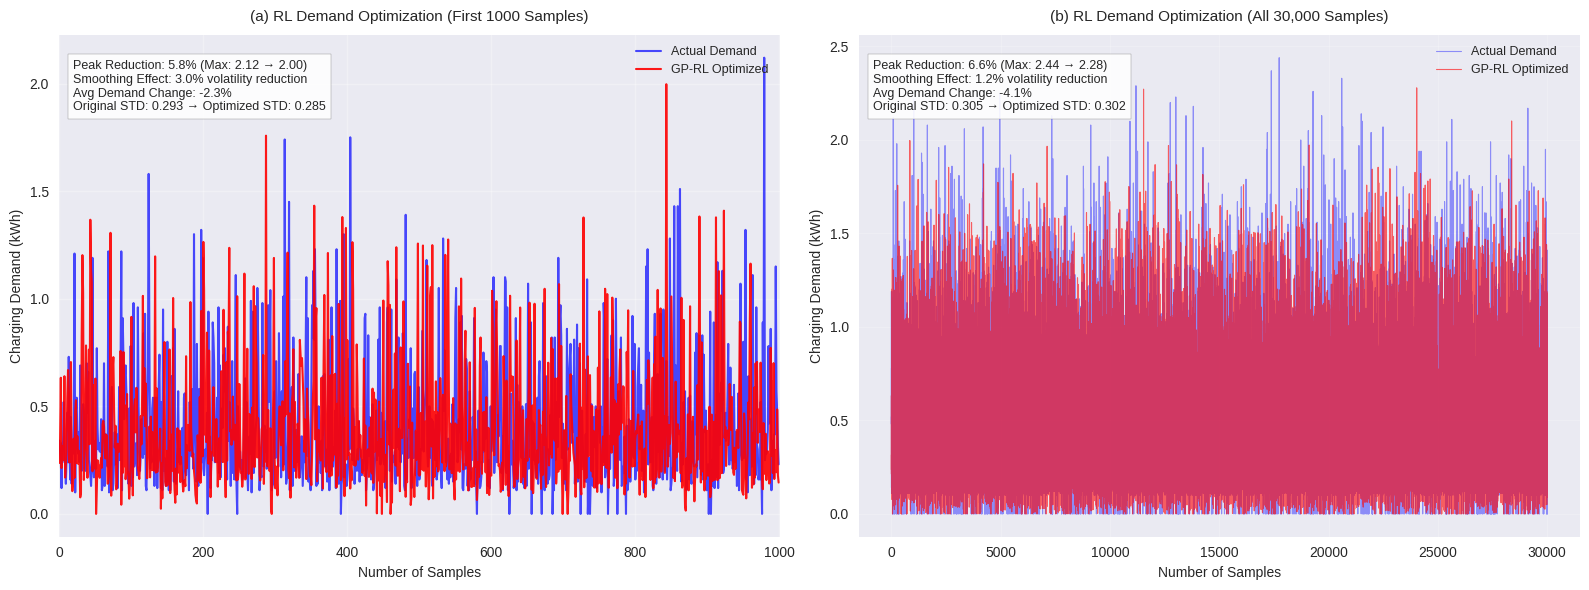


=== RL Optimization Statistics ===
Peak demand reduction: 6.6%
Average Price: 0.371 €/kWh
Price Elasticity: -0.190


In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

plt.figure(figsize=(16, 6))  # Adjusted figure size for 1 row of plots
plt.style.use('seaborn-v0_8')

# ==============================================
# Part 1: CatBoost-RL results
# ==============================================
with open('/content/drive/MyDrive/EVD/data/saved_predictions/hybrid_cb_gp_rl_results.pkl', 'rb') as f:
    rl_results = pickle.load(f)

all_y_test_rl = rl_results['test_results']['y_true']

# Prepare data for all samples optimization plot
n_samples = len(all_y_test_rl)
all_original_demand_rl = []
all_rl_demands = []

k_folds = 10
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
X = pd.DataFrame(np.zeros((n_samples, 7)))

for fold, (_, val_idx) in enumerate(kf.split(X)):
    original_demand_fold = all_y_test_rl[val_idx]
    rl_demands_fold = rl_results['rl_results']['demands'][fold]
    min_length = min(len(original_demand_fold), len(rl_demands_fold))
    all_original_demand_rl.extend(original_demand_fold[:min_length])
    all_rl_demands.extend(rl_demands_fold[:min_length])

# ==============================================
# Create the RL plots only (1x2 grid)
# ==============================================
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

# (a) RL first 1000 samples
axs[0].plot(all_y_test_rl[:1000], 'b-', alpha=0.7, label='Actual Demand', linewidth=1.5)
axs[0].plot(rl_results['rl_results']['demands'][0][:1000], 'r-', alpha=0.9, label='GP-RL Optimized', linewidth=1.5)
axs[0].set_xlabel('Number of Samples', fontsize=10)
axs[0].set_ylabel('Charging Demand (kWh)', fontsize=10)
axs[0].set_title('(a) RL Demand Optimization (First 1000 Samples)', fontsize=11, pad=10)
axs[0].legend(loc='upper right', fontsize=9, framealpha=1)
axs[0].grid(alpha=0.3)
axs[0].set_xlim(-1, 1001)

# Metrics for (a)
first_1000_actual_rl = all_y_test_rl[:1000]
first_1000_optimized_rl = rl_results['rl_results']['demands'][0][:1000]
peak_reduction_1000_rl = 100 * (1 - np.max(first_1000_optimized_rl)/np.max(first_1000_actual_rl))
original_std_1000_rl = np.std(first_1000_actual_rl)
optimized_std_1000_rl = np.std(first_1000_optimized_rl)
smoothing_1000_rl = 100 * (1 - (optimized_std_1000_rl/original_std_1000_rl))
avg_demand_change_1000_rl = 100 * ((np.mean(first_1000_optimized_rl) - np.mean(first_1000_actual_rl))/np.mean(first_1000_actual_rl))

metric_text_1000_rl = (
    f'Peak Reduction: {peak_reduction_1000_rl:.1f}% (Max: {np.max(first_1000_actual_rl):.2f} → {np.max(first_1000_optimized_rl):.2f})\n'
    f'Smoothing Effect: {smoothing_1000_rl:.1f}% volatility reduction\n'
    f'Avg Demand Change: {avg_demand_change_1000_rl:+.1f}%\n'
    f'Original STD: {original_std_1000_rl:.3f} → Optimized STD: {optimized_std_1000_rl:.3f}'
)
axs[0].text(0.02, 0.95, metric_text_1000_rl, transform=axs[0].transAxes,
          bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray'),
          fontsize=9, verticalalignment='top')

# (b) RL all samples
axs[1].plot(all_original_demand_rl, 'b-', alpha=0.4, label='Actual Demand', linewidth=0.8)
axs[1].plot(all_rl_demands, 'r-', alpha=0.6, label='GP-RL Optimized', linewidth=0.8)
axs[1].set_xlabel('Number of Samples', fontsize=10)
axs[1].set_ylabel('Charging Demand (kWh)', fontsize=10)
axs[1].set_title('(b) RL Demand Optimization (All 30,000 Samples)', fontsize=11, pad=10)
axs[1].legend(loc='upper right', fontsize=9, framealpha=1)
axs[1].grid(alpha=0.2)

# Metrics for (b)
peak_reduction_rl = 100 * (1 - np.max(all_rl_demands)/np.max(all_original_demand_rl))
original_std_rl = np.std(all_original_demand_rl)
optimized_std_rl = np.std(all_rl_demands)
smoothing_rl = 100 * (1 - (optimized_std_rl/original_std_rl))
avg_demand_change_rl = 100 * ((np.mean(all_rl_demands) - np.mean(all_original_demand_rl))/np.mean(all_original_demand_rl))

metric_text_rl = (
    f'Peak Reduction: {peak_reduction_rl:.1f}% (Max: {np.max(all_original_demand_rl):.2f} → {np.max(all_rl_demands):.2f})\n'
    f'Smoothing Effect: {smoothing_rl:.1f}% volatility reduction\n'
    f'Avg Demand Change: {avg_demand_change_rl:+.1f}%\n'
    f'Original STD: {original_std_rl:.3f} → Optimized STD: {optimized_std_rl:.3f}'
)
axs[1].text(0.02, 0.95, metric_text_rl, transform=axs[1].transAxes,
         bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray'),
         fontsize=9, verticalalignment='top')

# Save and show
plt.tight_layout()
plt.savefig('rl_optimization_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Print optimization statistics
print("\n=== RL Optimization Statistics ===")
print(f"Peak demand reduction: {peak_reduction_rl:.1f}%")
print(f"Average Price: {rl_results['rl_results']['price_stats']['mean']:.3f} €/kWh")
print(f"Price Elasticity: {rl_results['rl_results']['elasticity']:.3f}")